In [123]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.io import sql
import MySQLdb
import numpy as notebookp
import sklearn.ensemble
import math
import pprint
import time

from sklearn.model_selection import StratifiedKFold, train_test_split, GroupShuffleSplit
from sklearn.feature_selection import mutual_info_classif, RFECV, mutual_info_regression, SequentialFeatureSelector
from tqdm import tqdm 

# Warnings
import warnings
warnings.filterwarnings("ignore")

### Define functions:

In [2]:
DEFAULT_COLS = [
                'prop_log_historical_price',
                'prop_location_score1',
                'prop_location_score2',
                'loghistp_by_mean',
                'srch_room_count',
                'avg_by_price_by_mean',
                'star_by_price',
                'rev_by_price_by_mean',
                'price_by_med',
                'srch_booking_window',
                'ploc_score2_by_mean',
                'book_per_pcnt_by_mean',
                'prop_cnt',
                'promo_per_procnt',
                'train_price_avg',
                'random_bool',
                'avg_by_price',
                'srch_query_affinity_score',
                'ploc_score1_by_mean',
                'srch_length_of_stay',
                'visitor_hist_adr_usd',
                'price_usd',
                'promo_perprocnt_by_mean',
                'book_per_pcnt',
                'srch_children_count',
                'rev_by_price',
                'promotion_cnt',
                'srch_adults_count',
                'star_by_price_by_mean',
                'click_nobook_per_pcnt',
                'prop_review_score',
                'click_nobper_pcnt_by_mean']

def trainer(train_df, col_list = None, model = None, train_loc1 = 3499709, train_loc2 = 4499607, cv_loc1 = 4499608, cv_loc2 = 4958347, print_factors = True, return_model = False, target= 'click_bool'):
    """
    >>trainer(train_df, col_list, model = None, train_loc1 = 7000014, train_loc2 = 9000007, 
              cv_loc1 = 9000008, cv_loc2 = 9917530, print_factors = True)
    
    Given pd.DataFrame of Expedia Personalized Search training data, 
    [list of columns in DF to train on], and optionally a SciKitLearn model.  Fit the model to classify rows
    based on "click_bool" parameter (train on the rows train_loc1 to train_loc2 inclusive).  Calculate the NDCG 
    on a validation sample (rows: cv_loc1 to cv_loc2).
    Optionally print an ordered list of the column names and their "feature_importances" with print_factors.
    Optionally return_model, e.g. for use with Test data.
    """
    
    if col_list is None:
        col_list = DEFAULT_COLS


    #exclude outlying prices for training.
    train_df = train_df.loc[(train_df['price_usd'] <= 2000.0) * (train_df['price_usd'] != 0.0)]
    
    if model is None:
        model = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000)
    
#     model.fit(train_df.loc[train_loc1:train_loc2, col_list], train_df.loc[train_loc1:train_loc2, "click_bool"])
    model.fit(train_df.loc[train_loc1:train_loc2, col_list], train_df.loc[train_loc1:train_loc2, target])
    
    feature_scores_pairs = [[model.feature_importances_[i], col_list[i]] for i in range(len(col_list))]
    
    if hasattr(model, 'predict_proba'):
        crossval_pred_arr = model.predict_proba(train_df.loc[cv_loc1:cv_loc2, col_list])[:, 1]
    else:
        crossval_pred_arr = model.predict(train_df.loc[cv_loc1:cv_loc2, col_list])

    ndcg = ndcg_calc(train_df.loc[cv_loc1:cv_loc2], crossval_pred_arr)
    
    if print_factors:
        print ("NDCG:", ndcg)
        print ("Feature Importances:")
        pprint.pprint(sorted(feature_scores_pairs, reverse = True))
        print (model)
    
    if return_model:
        return model
    else:
        return ndcg

def ndcg_calc(train_df, pred_scores):
    """
    >>ndcg_calc(train_df, pred_scores)
       train_df: pd.DataFrame with Expedia Columns: 'srch_id', 'booking_bool', 'click_bool'
       pred_scores: np.Array like vector of scores with length = num. rows in train_df
       
    Calculate Normalized Discounted Cumulative Gain for a dataset is ranked with pred_scores (higher score = higher rank).
    If 'booking_bool' == 1 then that result gets 5 points.  If 'click_bool' == 1 then that result gets 1 point (except:
    'booking_bool' = 1 implies 'click_bool' = 1, so only award 5 points total).  
    
    NDCG = DCG / IDCG
    DCG = Sum( (2 ** points - 1) / log2(rank_in_results + 1) )
    IDCG = Maximum possible DCG given the set of bookings/clicks in the training sample.
    
    """
    eval_df = train_df[['srch_id', 'booking_bool', 'click_bool']]
    eval_df['score'] = pred_scores

    logger = lambda x: math.log(x + 1, 2)
    eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)

    book_dcg = (eval_df['booking_bool'] * 31.0 / eval_df['log_rank']).sum() #where 2 ** 5 - 1.0 = 31.0
    book_idcg = (31.0 * eval_df['booking_bool']).sum()
    
    click_dcg = (eval_df['click_bool'] * (eval_df['booking_bool'] == 0) / eval_df['log_rank']).sum()
    
    # Max number of clicks in training set is 30.
    # Calculate the 31 different contributions to IDCG that 0 to 30 clicks have
    # and put in dict {num of click: IDCG value}.
    disc = [1.0 / math.log(i + 1, 2) if i != 0 else 0 for i in range(31)]
    disc_dict = { i: np.array(disc).cumsum()[i] for i in range(31)}
    
    # Map the number of clicks to its IDCG and subtract off any clicks due to bookings
    # since these were accounted for in book_idcg.
    click_idcg = (eval_df.groupby(by = 'srch_id')['click_bool'].sum().map(disc_dict) - eval_df.groupby(by = 'srch_id')['booking_bool'].sum()).sum()

    return (book_dcg + click_dcg) / (book_idcg + click_idcg)

def df_from_query(row_start = 3499709, row_end = 4958347, training = True, srch_start = None, srch_end = None):
    """
    >>df_from_query(row_start = 7000014, row_end = 9917530, training = True, srch_start = None, srch_end = None)
      row_start,row_end: Row number range (inclusive) to request from MySQL db (faster than srch_start,srch_end)
      srch_start,srch_end: Search ID range (inclusive) to request (slower than by row_start,row_end)
      training: BOOL, to pull from Training data set to True, set to False for Test data.
    
    Query local MySQL database, (see dbcon, below for permissions) to build a pd.DataFrame for training/testing.
    
    Several columns depend on summary statistics about Properties in the PropFactors/PropFactors7M tables in the
    database.  The "7M" suffix denotes summary statistics from the first 7000013 rows which for training
    are used with the latter ~3M rows. (This is to have these latter rows more closely resemble the test set, since some 
    properties only appear a few times so the "booking_cnt" statistic is an overly strong signal if it includes 
    information from the row that is being used for training.)  However for building the Test Set predictions, it
    is better to use statistics from the entire training set.
    Since some properties will appear in the training/test sets but not among the summary sets, columns that depend
    on these statistics are set to zero.
    Can select data by row_num or srch_id (row_num is the primary key so is faster, but it may be preferrable to 
    select by srch_id where splitting searches between chunks could cause problems, like when compiling test data).
    The presence of srch_start and srch_end overrides row_start/row_end.
    
    
    """
    
    dbcon = MySQLdb.connect('localhost', 'root', 'root', 'DMT')
    #print('Run Ok')
    # MySQL server, user, password, and database

    main_cols = "SELECT row_num, srch_id, s.prop_id, price_usd, prop_location_score1, prop_location_score2, prop_log_historical_price, prop_review_score, random_bool, srch_adults_count, srch_booking_window, srch_children_count, srch_length_of_stay, srch_query_affinity_score, srch_room_count, visitor_hist_adr_usd, (prop_starrating / price_usd) AS star_by_price, (prop_review_score / price_usd) AS rev_by_price"

    agg_cols = ", prop_cnt, promotion_cnt, train_price_avg, (booking_cnt / prop_cnt) AS book_per_pcnt, (promotion_flag / promotion_cnt) AS promo_per_procnt, (train_price_avg / price_usd) AS avg_by_price, ((click_cnt - booking_cnt) / prop_cnt) AS click_nobook_per_pcnt"

    agg_missing = ", 0 AS prop_cnt, 0 AS promotion_cnt, 0 AS train_price_avg, 0 AS book_per_pcnt, 0 AS promo_per_procnt, 0 AS avg_by_price, 0 AS click_nobook_per_pcnt"

    if training:
        from_tables1 = ", booking_bool, click_bool FROM TrainSearch AS s, PropFactors3M AS p"
        from_tables2 = ", booking_bool, click_bool FROM TrainSearch AS s"
        missing_from_table = "PropFactors3M"
    else:
        from_tables1 = " FROM TestSearch AS s, PropFactors AS p"
        from_tables2 = " FROM TestSearch AS s"
        missing_from_table = "PropFactors"

    if (srch_start is not None) or (srch_end is not None):
        if (srch_start is None):
            raise Exception("Expected selection pair (srch_start, srch_end) OR (row_start, row_end). Got: srch_start = None")
        elif (srch_end is None):
            raise Exception("Expected selection pair (srch_start, srch_end) OR (row_start, row_end). Got: srch_end = None")
        else: 
            where_str = " AND srch_id >= " + str(srch_start) + " AND srch_id <= " + str(srch_end) + ";"
    else:
        where_str = " AND row_num >= " + str(row_start) + " AND row_num <= "+ str(row_end) + ";"

    train_dfmost = pd.read_sql(main_cols + agg_cols + from_tables1 + " WHERE p.prop_id = s.prop_id" + where_str, con = dbcon, index_col = 'row_num')
    # DataFrame.to_sql(name, con, schema=None, if_exists='fail', index=True, index_label=None, chunksize=None, dtype=None, method=None)
    train_dfpropmissing = pd.read_sql(main_cols + agg_missing + from_tables2 + " WHERE prop_id NOT IN (SELECT prop_id FROM " + missing_from_table + ")" + where_str, con = dbcon, index_col = 'row_num')
    
    dbcon.close()
    
    #display(train_dfmost.head(3))
    #print(train_dfmost.shape)
    #display(train_dfpropmissing.head(3))
    #print(train_dfpropmissing.shape)

    train_df = pd.concat([train_dfmost, train_dfpropmissing])
    train_df.sort_values(by='row_num',inplace = True)
    
    
    train_df.fillna(value = 0, inplace = True)

    return train_df

def agg_by_srch(train_df):
    """
    >>agg_by_srch(train_df)
    
    Given a training/testing dataset that includes the columns listed in cols_in below, calculate
    new columns that normalize these values among the search in which they appear by dividing by
    the mean (or median for 'price_usd' since it has higher variance).  i.e. given prop_location_score "j"
    for search "i" add column: prop_location_score[i][j] / mean(prop_location_score[i])
    """
    
    cols_in = ['prop_location_score1', 
               'prop_location_score2', 
               'book_per_pcnt', 
               'avg_by_price', 
               'rev_by_price', 
               'star_by_price', 
               'promo_per_procnt',
               'prop_log_historical_price', 
               'click_nobook_per_pcnt']

    cols_out = ['srch_ploc_score1_mean', 
                'srch_ploc_score2_mean', 
                'srch_book_per_pcnt_mean', 
                'srch_avg_by_price_mean', 
                'srch_rev_by_price_mean', 
                'srch_star_by_price_mean', 
                'srch_promo_per_procnt_mean', 
                'srch_prop_log_historical_price_mean', 
                'click_nobook_per_pcnt_mean']

    srch_df = train_df[['srch_id'] + cols_in].groupby(by='srch_id').mean()
    srch_df.columns = cols_out

    srch_df['srch_price_med'] = train_df[['srch_id','price_usd']].groupby(by = 'srch_id').median()
    srch_df['srch_id'] = srch_df.index
    
    cols_inp = list(cols_in)
    cols_outp = list(cols_out)
    cols_inp.append('price_usd')
    cols_outp.append('srch_price_med')

    cols_agg = ['ploc_score1_by_mean', 
                'ploc_score2_by_mean', 
                'book_per_pcnt_by_mean', 
                'avg_by_price_by_mean', 
                'rev_by_price_by_mean', 
                'star_by_price_by_mean', 
                'promo_perprocnt_by_mean', 
                'loghistp_by_mean', 
                'click_nobper_pcnt_by_mean',
                'price_by_med']

    for i in range(len(cols_inp)):
        train_df[cols_agg[i]] = train_df[cols_inp[i]] / train_df.join(srch_df[['srch_id', cols_outp[i]]], on='srch_id', rsuffix = '_agg')[cols_outp[i]]
    
    train_df.fillna(value = 0, inplace = True)
    train_df.loc[train_df.price_by_med == np.inf, 'price_by_med'] = 0

    return train_df

def test_pred_sorted(test_df, model, cols = None, regress_model = False):
    """
    >>test_pred_sorted(test_df, model, cols, regress_model = False)
        test_df: pd.DataFrame that contains columns listed in cols.
        model: SciKitLearn model used for ranking.
        cols: [list of strs] columns in test_df to send to model.
        regress: BOOL, Regressor Model used, as opposed to Classifier.
    
    Return a pd.DataFrame that contains 'srch_id', and 'property_id' columns such that
    the properties are listed in descending order of their model score within each search.
    
    To save output use: test_out_df.to_csv("FILE OUT", index = False, cols = ['srch_id', 'prop_id'], header = ['SearchId','PropertyId'])
    """
    if cols is None:
        cols = DEFAULT_COLS

    if regress_model:
        scores = model.predict(test_df[cols])
    else:
        scores = model.predict_proba(test_df[cols])[:, 1]
    test_df['sort_score'] = scores
     
    return test_df[['srch_id', 'prop_id', 'sort_score']].sort_values(by=['srch_id', 'sort_score'], ascending = [True, False])

### Creat train set and add agg property data of first 3.5M rows for internal optimization and validation purposes:


In [85]:
tic= time.time()
train_df = df_from_query()
toc= time.time()

print('Elapsed time to load train df is {} seconds'.format(toc-tic))

Elapsed time to load train df is 39.137526750564575 seconds


In [86]:
agg_by_srch(train_df)  

train_df['Relevance_target']= train_df['click_bool']*1
train_df['Relevance_target']+= train_df['booking_bool']*4

### Model and give validation ndcg for different models (only train/validate on last 1.5M rows, since first 3.5M rows are used in agg property data):

In [11]:
tic= time.time()
rfc_model = trainer(train_df, return_model = True, target='click_bool')
toc= time.time()

print('Elapsed time to train model is {} seconds'.format(toc-tic))

C:\Users\stijn\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
<ipython-input-2-88a6e7bdce26>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['score'] = pred_scores


NDCG: 0.5284163831479504
Feature Importances:
[[0.1557509599155477, 'ploc_score2_by_mean'],
 [0.08663035558170415, 'prop_location_score2'],
 [0.08374515350875267, 'book_per_pcnt'],
 [0.08352201008186176, 'star_by_price_by_mean'],
 [0.08162710898056694, 'avg_by_price_by_mean'],
 [0.0667352129139011, 'book_per_pcnt_by_mean'],
 [0.04011483613971421, 'rev_by_price_by_mean'],
 [0.03240815323235218, 'loghistp_by_mean'],
 [0.030623651364555315, 'ploc_score1_by_mean'],
 [0.0298330697221032, 'avg_by_price'],
 [0.028712863592985756, 'prop_location_score1'],
 [0.027442648574105555, 'price_by_med'],
 [0.026755474171465097, 'click_nobook_per_pcnt'],
 [0.02333360399021113, 'click_nobper_pcnt_by_mean'],
 [0.02240115278396501, 'train_price_avg'],
 [0.01974601685650187, 'star_by_price'],
 [0.019128783983361975, 'prop_cnt'],
 [0.018781513984028178, 'price_usd'],
 [0.016240742417494874, 'rev_by_price'],
 [0.015158113384530311, 'promo_perprocnt_by_mean'],
 [0.01292322558627544, 'prop_log_historical_price'

<ipython-input-2-88a6e7bdce26>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


### Creat full model by training on last 1.5M rows of data and not validating (still not use first 3.5M rows since they are used for agg prop data):

In [33]:
#Model validation ndcg score is not representative/biased since trained on total dataset (excluding first 3.5M rows ofc)

model = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000)

tic= time.time()
final_model = trainer(train_df, train_loc2=4958347, model=model, return_model = True)
toc= time.time()

print('Elapsed time to train final model is {} seconds'.format(toc-tic))

C:\Users\stijn\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
<ipython-input-2-88a6e7bdce26>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['score'] = pred_scores


NDCG: 0.6103639070175222
Feature Importances:
[[0.15399183599923447, 'ploc_score2_by_mean'],
 [0.08523192897567776, 'avg_by_price_by_mean'],
 [0.0844536134929379, 'prop_location_score2'],
 [0.07880892056610174, 'star_by_price_by_mean'],
 [0.078450088191829, 'book_per_pcnt_by_mean'],
 [0.07540727970738842, 'book_per_pcnt'],
 [0.040807325505551766, 'rev_by_price_by_mean'],
 [0.032515032049409545, 'loghistp_by_mean'],
 [0.03104710824162709, 'ploc_score1_by_mean'],
 [0.030764678602658985, 'prop_location_score1'],
 [0.028496806859129035, 'click_nobook_per_pcnt'],
 [0.02822642478631406, 'avg_by_price'],
 [0.026412516002341818, 'price_by_med'],
 [0.023186206005757843, 'click_nobper_pcnt_by_mean'],
 [0.022508375418892508, 'train_price_avg'],
 [0.01939639234420508, 'prop_cnt'],
 [0.018954824337002175, 'price_usd'],
 [0.018169303765378453, 'star_by_price'],
 [0.016723843569083977, 'rev_by_price'],
 [0.014648095659474534, 'promo_perprocnt_by_mean'],
 [0.012559484652844455, 'prop_log_historical_pr

<ipython-input-2-88a6e7bdce26>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)


### Create test df and add aggregated property data of all train data

In [24]:
#No need to change this!
tic= time.time()
test_df = df_from_query(training = False, row_start=1, row_end=4959183)
toc= time.time()

print('Elapsed time to load test df is {} seconds'.format(toc-tic))

Elapsed time to load test df is 119.97753405570984 seconds


In [26]:
agg_by_srch(test_df) 

,srch_id,prop_id,price_usd,prop_location_score1,prop_location_score2,prop_log_historical_price,prop_review_score,random_bool,srch_adults_count,srch_booking_window,...,ploc_score1_by_mean,ploc_score2_by_mean,book_per_pcnt_by_mean,avg_by_price_by_mean,rev_by_price_by_mean,star_by_price_by_mean,promo_perprocnt_by_mean,loghistp_by_mean,click_nobper_pcnt_by_mean,price_by_med
row_num,,,,,,,,,,,,,,,,,,,,,
1,1,3180,119.00,2.94,0.0691,5.03,4.5,0,2,10,...,1.104977,0.551112,1.857590,1.040978,0.807452,0.815330,0.0,1.084293,0.000000,1.414141
2,1,5543,118.00,2.64,0.0843,4.93,4.5,0,2,10,...,0.992224,0.672341,2.302547,0.972965,0.814295,0.822239,0.0,1.062737,1.561392,1.402258
3,1,14142,49.00,2.71,0.0556,4.16,3.5,0,2,10,...,1.018533,0.443442,0.578877,1.058088,1.525188,1.320058,0.0,0.896752,2.551543,0.582294
4,1,22393,143.00,2.40,0.0561,5.03,4.5,0,2,10,...,0.902022,0.447430,0.596157,0.900182,0.671936,0.678491,0.0,1.084293,0.000000,1.699346
5,1,24194,79.00,2.94,0.2090,4.72,4.5,0,2,10,...,1.104977,1.666896,0.630717,1.116166,1.216289,1.228155,0.0,1.017468,0.933027,0.938800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959179,332787,32019,66.07,2.48,0.0551,4.53,3.5,0,1,7,...,1.061774,0.504843,0.000000,0.953062,1.399759,1.097234,0.0,0.977497,0.000000,0.943183
4959180,332787,33959,67.10,2.20,0.3344,4.39,3.0,0,1,7,...,0.941896,3.063874,3.957038,0.879107,1.181376,1.080391,0.0,0.947287,0.000000,0.957887
4959181,332787,35240,73.91,1.79,0.0000,4.64,0.0,0,1,7,...,0.766361,0.000000,0.000000,0.818886,0.000000,0.980845,0.0,1.001233,0.000000,1.055103


### Create predictions based on full model and test_df:

In [36]:
pred_df = test_pred_sorted(test_df, final_model)

KeyboardInterrupt: 

In [48]:
pred_df

,srch_id,prop_id,sort_score
row_num,,,
24,1,99484,0.128669
6,1,28181,0.113553
10,1,54937,0.109641
7,1,34263,0.085479
13,1,61934,0.083393
...,...,...,...
4959182,332787,94437,0.055810
4959178,332787,29018,0.052577
4959183,332787,99509,0.046378


In [35]:
Results= pred_df[['srch_id', 'prop_id']]
Results.to_csv('Results\Results_group77_3.csv', index=False)

# We can do all our analysis on this small train_df for faster computation time below here:

rather not change the stuff above since we will only need it in our final model

Create small trainer we can use for our own optimisation stuff:

In [125]:
def small_trainer(df, col_list=None, model=None, train_size=0.8, print_factors = True, return_model = False, target= 'click_bool'):
    
    if col_list is None:
        col_list = DEFAULT_COLS

    #exclude outlying prices for training.
    df = df.loc[(df['price_usd'] <= 2000.0) * (df['price_usd'] != 0.0)]
    
    if model is None:
        model = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000)

    # Divide data into training and validation subsets
    train_inds, test_inds = next(GroupShuffleSplit(train_size=train_size, n_splits=2, random_state = 7).split(df, groups=df['srch_id']))
    
    model.fit(df.iloc[train_inds][col_list], df.iloc[train_inds][target])
    
    feature_scores_pairs = [[model.feature_importances_[i], col_list[i]] for i in range(len(col_list))]
    
    if hasattr(model, 'predict_proba'):
        crossval_pred_arr = model.predict_proba(df.iloc[test_inds][col_list])[:, 1]
    else:
        crossval_pred_arr = model.predict(df.iloc[test_inds][col_list])

    ndcg = ndcg_calc(df.iloc[test_inds], crossval_pred_arr)
    feature_scores = sorted(feature_scores_pairs, reverse = True)
    
    if print_factors:
        print ("NDCG:", ndcg)
        print ("Feature Importances:")
        pprint.pprint(sorted(feature_scores_pairs, reverse = True))
        print (model)
    
    if return_model:
        return model
    else:
        return ndcg, feature_scores
    return

def optimizer(df, features_to_prune = 20, return_data=False):
    
    # exclude the target and other unnecessary columns
    cols = [col for col in df.columns if col not in ['srch_id', 'prop_id','booking_bool','click_bool', 'Relevance_target']]
    
    NDCG , pruned_features, comp_times = [], [], []
    #because the 1st iteration is for the full model , run the iteration with features_to_prune + 1
    for i in tqdm(range(0,features_to_prune+1)):
       
        tic = time.time()
        if i==features_to_prune:
            ndcg, feature_list = small_trainer(df, cols)
        else:
            ndcg, feature_list = small_trainer(df, cols, print_factors=False)
        toc = time.time()
        
        pruned = feature_list[-1][1]
        
        NDCG.append(ndcg)
        comp_times.append(toc-tic)
        pruned_features.append(pruned)
        
        cols = [j for j in cols if j not in [pruned]]
    
    pruned_features.insert(0,'full model')
    pruned_features = pruned_features[0:-1]
    
    #plotter
    fig, ax1 = plt.subplots(dpi=150)

    x = np.arange(0,len(pruned_features))
    labels = pruned_features

    ax1.set_xticks(range(0,len(pruned_features)))
    ax1.set_xticklabels(labels, rotation=90,fontsize='small')

    ax1.set_xlabel('Pruned Feature(s)')
    ax1.set_ylabel('NDCG', color='red')
    ax1.plot(x, NDCG, 'ro-')
    ax1.tick_params(axis='y', labelcolor='red')

    ax2 = ax1.twinx() 

    ax2.set_ylabel('Training time (in secs)', color='blue') 
    ax2.plot(x, comp_times, 'bo-')
    ax2.tick_params(axis='y', labelcolor='blue')
    plt.title('NDCG and training times for sequential'+'\n'+'pruning of least important features')
    plt.grid()
    
    if return_data:
        return NDCG, pruned_features, comp_times

In [145]:
smalltrain_df= train_df[:int(1e5)]

In [148]:
col_list= ['ploc_score2_by_mean', 'avg_by_price_by_mean', 'prop_location_score2', 'star_by_price_by_mean', 'book_per_pcnt_by_mean']

tic= time.time()
model= small_trainer(smalltrain_df, col_list=col_list, return_model=True)
toc= time.time()

print('Elapsed time to train small model is {} seconds'.format(toc-tic))


NDCG: 0.49974432305031635
Feature Importances:
[[0.2946329804149497, 'ploc_score2_by_mean'],
 [0.1961784331676882, 'star_by_price_by_mean'],
 [0.191060948218719, 'book_per_pcnt_by_mean'],
 [0.17591613126308644, 'avg_by_price_by_mean'],
 [0.14221150693555673, 'prop_location_score2']]
RandomForestClassifier(min_samples_split=1000)
Elapsed time to train small model is 11.005942344665527 seconds


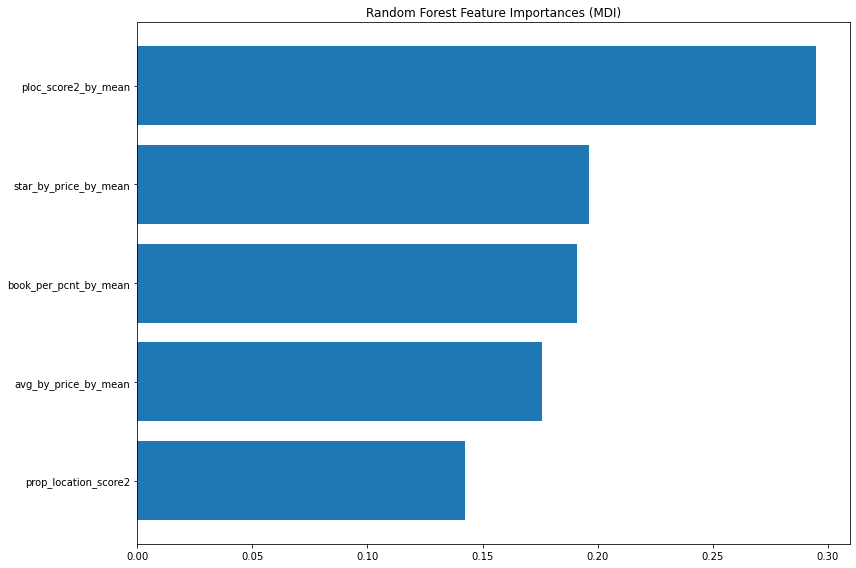

In [149]:
tree_feature_importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
#indices = np.argsort(importances)[::-1]

feature_names = np.array(col_list)

#tree_feature_importances = ( rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort().tolist()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=[12,8])
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()
#fig.savefig('rfr_importance.png', dpi = 200)

### NDCG Scores & runtimes when sequentially pruning the least important features 

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [09:32<00:00, 17.89s/it]

NDCG: 0.4299279316877211
Feature Importances:
[[1.0, 'ploc_score2_by_mean']]
RandomForestClassifier(min_samples_split=1000)


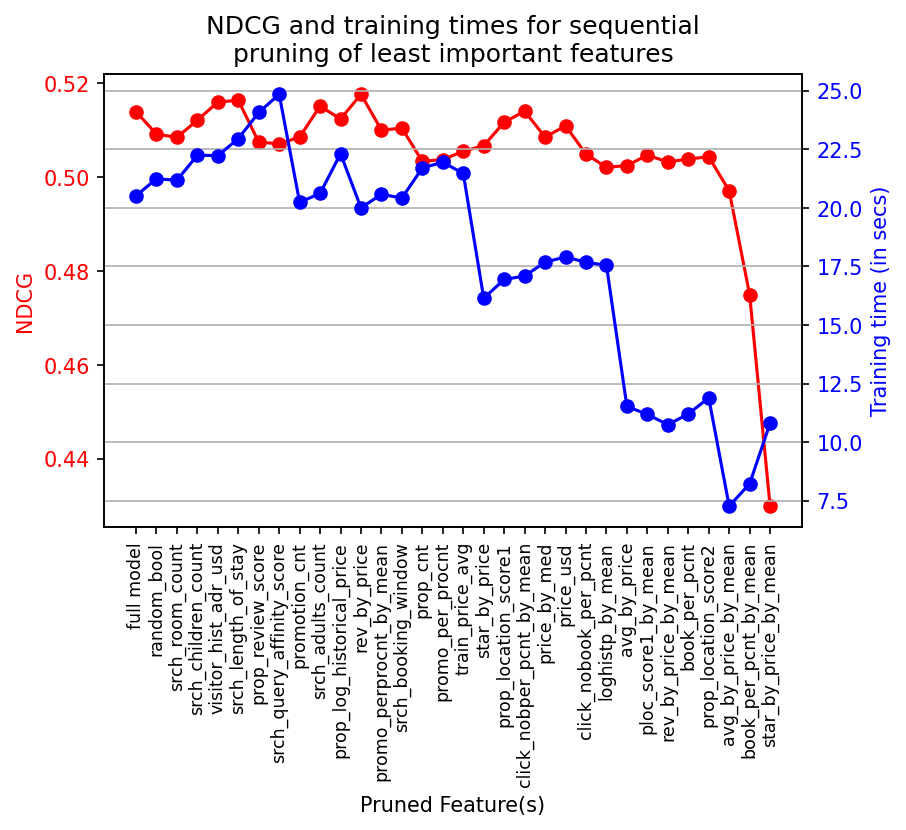

In [150]:
# using the small train set (with 1e5 rows)
optimizer(smalltrain_df, features_to_prune = 31)

### Sequential Feature Selection(SFS)

SFS is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. This can done either in a forward and backward manner. In a forward SFS we start with zero feature and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the $\text{n_features_to_select}$ parameter.

Backward-SFS follows the same idea but works in the opposite direction: instead of starting with no feature and greedily adding features, we start with all the features and greedily remove features from the set. 

Paper about this- http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.24.4369&rep=rep1&type=pdf

In [151]:
Estimator = sklearn.ensemble.RandomForestRegressor(n_estimators = 100, min_samples_split = 1000, random_state=0)
# Estimator = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000, random_state=0)
# Estimator = svm.SVR()

train_inds, test_inds = next(GroupShuffleSplit(train_size=0.8, n_splits=2, random_state = 7).split(smalltrain_df, groups=smalltrain_df['srch_id']))

tic_fwd = time.time()
sfs_forward = SequentialFeatureSelector(Estimator, n_features_to_select=10, n_jobs=-1, direction='forward')
sfs_forward= sfs_forward.fit(smalltrain_df.iloc[train_inds][DEFAULT_COLS], smalltrain_df.iloc[train_inds]['click_bool'])
toc_fwd = time.time()

tic_fwd = time.time()
sfs_backward = SequentialFeatureSelector(Estimator, n_features_to_select=10, n_jobs=-1, direction='backward')
sfs_backward= sfs_backward.fit(smalltrain_df.iloc[train_inds][DEFAULT_COLS], smalltrain_df.iloc[train_inds]['click_bool'])
toc_fwd = time.time()

print("Features selected by forward sequential selection: "f"{X_train.columns[sfs_forward.get_support()].tolist()}")
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print("Features selected by backward sequential selection: "f"{X_train.columns[sfs_backward.get_support()].tolist()}")
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

KeyboardInterrupt: 

I suggest:
1. We continue in examining the features we already have and maybe lose some of them since we have more than 30 right now
2. Looking into possible new interesting features to add
3. Try different models (neural networks etc.)